<a href="https://colab.research.google.com/github/amolgupta7/Hope-Speech-Detection/blob/main/Final_Hope_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install humanfriendly
!pip install datasets
!pip install transformers

In [2]:
import tensorflow as tf
import os
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive 
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, RobertaModel, RobertaConfig
from transformers import Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from humanfriendly import format_timespan
from datasets import load_metric
import warnings
warnings.filterwarnings('ignore')

Loading the GPU, if found.



In [3]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

Found GPU at: /device:GPU:0


'Tesla K80'

Mounting the drive to load the data from the drive.

In [4]:
drive.mount('/content/drive') #Connecting to drive.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading the dataset. Path can be altered

In [5]:
path = "drive/MyDrive/Codalab/HopeSpeech Detection For Equality, Diversity and, Inclusion"

In [6]:
df = pd.read_csv(os.path.join(path,"Hope_ENG_train.csv")) 
df_dev = pd.read_csv(os.path.join(path,"Hope_ENG_dev.csv"))
df_test = pd.read_csv(os.path.join(path,"Hope_ENG_test.csv"))

In [7]:
df.sample(10)

,Texts,label
18431,@Adrian Bingham It's definately not the bigge...,Non_hope_speech
3263,@Evelyne b prayer and faith are the only thing...,Non_hope_speech
5427,Francesca nnAll these problems that they ran i...,Non_hope_speech
14980,OMG I love Crystal’s innocence! She is such a ...,Hope_speech
19944,@THIS IS ME,Non_hope_speech
21994,She's not well is she. Souless hate is not a g...,Non_hope_speech
4280,@colorbar.s she literally came out as bisexual,Hope_speech
2600,THEIR JEANS ARE EVEN CUFFED LIKE WTF,Non_hope_speech
5592,BS wasted conversation perpetuating the racism...,Non_hope_speech
12817,Nobody expects the overused Monty Python quote!,Non_hope_speech


In [8]:
df_dev.sample(10)

,Texts,label
125,She maybe thinks she is caucasian lol,Non_hope_speech
932,Just because she said she isn’t okay with Homo...,Non_hope_speech
2001,All life's matter,Hope_speech
1817,Finally our history is out of the shadows. Bla...,Non_hope_speech
1278,By the way I think she looks great,Non_hope_speech
2144,Ketnipz They assumed,Non_hope_speech
1121,I was so SURE about that like,Non_hope_speech
1726,@Suicide Booth but these idiots miss that out ...,Non_hope_speech
1054,Turn off fox,Non_hope_speech
2527,Should we tell them about the past popes...,Non_hope_speech


In [9]:
df_test.sample(10)

,Texts
18,man shall not sleep with man is actually man s...
1106,Fake biased CNN and leftside are dangerouse an...
1673,It’s not controversial
1938,All lives can not matter if black lives don't ...
1912,Injustice is people getting fire for telling t...
1068,willholt11 no.. every American “singling our A...
557,It's funny how she's turned into a virtue sign...
1320,“Black lives matter.” Notice how it doesn’t sa...
2188,You god doesn't agree with all lives matter
1235,I trust in Madonna. That's all.


In [10]:
print(df.info(),end="\n\n")
print(df_dev.info(),end="\n\n")
print(df_test.info(),end="\n\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22740 entries, 0 to 22739
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Texts   22740 non-null  object
 1   label   22740 non-null  object
dtypes: object(2)
memory usage: 355.4+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2841 entries, 0 to 2840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Texts   2841 non-null   object
 1   label   2841 non-null   object
dtypes: object(2)
memory usage: 44.5+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2843 entries, 0 to 2842
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Texts   2843 non-null   object
dtypes: object(1)
memory usage: 22.3+ KB
None



Map each label to an integer number, where Hope speech is considered as 1 and Non Hope speech as 0

In [11]:
df['label'] = df['label'].map({'Hope_speech': 1, 'Non_hope_speech': 0})

In [12]:
df.sample(10)

,Texts,label
10259,@Public Public said the riot fan,0
13600,Well it has to get to 666 at one point.,0
9094,I feel sorry for this poor lost soul! What goo...,0
6431,U are such an inspiration,1
19891,@Nely Candelario Nely Candelario *cough * m...,0
4180,@ur mom is a cat victim mentality =!= being a ...,0
8394,People are getting killed just because there M...,0
17373,se lo dici tu wat do that means?,0
20601,Completely badass sherif won't take any bs... ...,0
6550,@Rocky SinainnKim Kardashian is also multimili...,0


In [13]:
df['label'].value_counts() # checking the count of 0's and 1's in the dataset, i.e., Hope speech and Non hope speech.

0    20778
1     1962
Name: label, dtype: int64

In [14]:
df.describe()

,label
count,22740.000000
mean,0.086280
std,0.280783
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


**Exploratory Data Analysis.(EDA)**

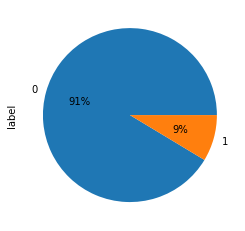

In [15]:
df.label.value_counts().plot(kind='pie',autopct='%1.0f%%') # Plotting the labels of data.

In [16]:
df_dev['label'] = df_dev['label'].map({'Hope_speech': 1, 'Non_hope_speech': 0})
df_dev.sample(10)

,Texts,label
906,Its been a week? Anybody? Democratic Liberal...,0
1933,You forgot the dark side of this “protest” wit...,0
1898,I don‘t think you really get what all this is ...,0
146,@Calvinist 1689 🤣 Don't be so quick to give Tr...,0
2463,@Sam Osler she's correct look harder,0
547,This woman always surprises me,0
730,It is just s book,0
865,@HooverDude 60 What kind of argument is that f...,0
512,As Long as we keep calling ourselves black we ...,0
114,Black Lives Don't Matter any more than Hispani...,1


In [17]:
df_dev['label'].value_counts()

0    2569
1     272
Name: label, dtype: int64

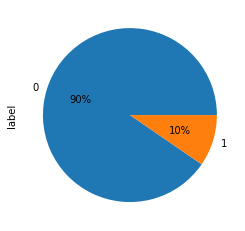

In [18]:
df_dev.label.value_counts().plot(kind='pie',autopct='%1.0f%%')

THe first step is to tokenize the values.
Transformers provides the pretrained Tokenizer. The tokenizer used here is Roberta-base

In [19]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length = 512)

Defining a function for printing the sample text after passing into tokenizer.

In [20]:
def sample_print(text):
  tokenized_txt=tokenizer.tokenize(text) #Passing into Tokenizer to Tokenize it.
  Token_ids=tokenizer.convert_tokens_to_ids(tokenized_txt) #Converting tokens to Id's 
  return tokenized_txt,Token_ids

In [21]:
X,Y=sample_print(df['Texts'][0])
print(" Texts-",df['Texts'][0],"\n","Tokenized_Text-",X,"\n","Token IDs-",Y)

 Texts- these tiktoks radiate gay chaotic energy and i love it 
 Tokenized_Text- ['these', 'Ġt', 'ik', 't', 'oks', 'Ġrad', 'iate', 'Ġgay', 'Ġchaotic', 'Ġenergy', 'Ġand', 'Ġi', 'Ġlove', 'Ġit'] 
 Token IDs- [29902, 326, 967, 90, 17015, 13206, 10599, 5100, 16529, 1007, 8, 939, 657, 24]


In [22]:
X,Y=sample_print(df_dev['Texts'][0])
print(" Texts-",df_dev['Texts'][0],"\n","Tokenized_Text-",X,"\n","Token IDs-",Y)

 Texts- Thats it.... like....I dont like that statue 
 Tokenized_Text- ['Th', 'ats', 'Ġit', '....', 'Ġlike', '....', 'I', 'Ġdont', 'Ġlike', 'Ġthat', 'Ġstatue'] 
 Token IDs- [11329, 2923, 24, 17220, 101, 17220, 100, 33976, 101, 14, 9577]


In [23]:
data_t=df['Texts'].tolist() #converting it to list for passing the whole dataset at a time
data_v=df_dev['Texts'].tolist()

In [24]:
X_train_tokenized=tokenizer(data_t, padding=True, truncation=True, max_length=512)
y_train=df['label'].to_list()
X_val_tokenized=tokenizer(data_v, padding=True, truncation=True, max_length=512)
y_val=df_dev['label'].to_list()

In [25]:
class Dataset(torch.utils.data.Dataset):    
    def __init__(self, encodings, labels=None):          
        self.encodings = encodings        
        self.labels = labels
     
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings["input_ids"])

In [26]:
train_dataset = Dataset(X_train_tokenized,y_train)
val_dataset = Dataset(X_val_tokenized,y_val)

  **MODEL**

In [27]:
configuration = RobertaConfig()
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
configuration = model.config

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [28]:
configuration

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [29]:
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [30]:
training_args = TrainingArguments(
    output_dir="./result",
    evaluation_strategy = "epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=4,
    do_predict=True,
)

In [31]:
trainer = Trainer(
model,
training_args,
train_dataset=train_dataset,
eval_dataset=val_dataset,
tokenizer=tokenizer
)

In [32]:
trainer.train()

***** Running training *****
  Num examples = 22740
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5688


Epoch,Training Loss,Validation Loss
1,0.210600,0.190423
2,0.163200,0.219315
3,0.125200,0.285602
4,0.071600,0.352087


Saving model checkpoint to ./result/checkpoint-500
Configuration saved in ./result/checkpoint-500/config.json
Model weights saved in ./result/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./result/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./result/checkpoint-500/special_tokens_map.json
Saving model checkpoint to ./result/checkpoint-1000
Configuration saved in ./result/checkpoint-1000/config.json
Model weights saved in ./result/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./result/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./result/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2841
  Batch size = 16
Saving model checkpoint to ./result/checkpoint-1500
Configuration saved in ./result/checkpoint-1500/config.json
Model weights saved in ./result/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./result/checkpoint-1500/tokenizer_config.json
Special to

TrainOutput(global_step=5688, training_loss=0.14478315884553933, metrics={'train_runtime': 8754.4603, 'train_samples_per_second': 10.39, 'train_steps_per_second': 0.65, 'total_flos': 1.28076706194912e+16, 'train_loss': 0.14478315884553933, 'epoch': 4.0})

# Prediction

In [37]:
predictions = trainer.predict(val_dataset)

***** Running Prediction *****
  Num examples = 2841
  Batch size = 16


In [38]:
y_true=df_dev['label']

In [39]:
y_preds = np.argmax(predictions.predictions, axis=-1)

In [57]:
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score
print(classification_report(y_true, y_preds))
print(accuracy_score(y_true,y_preds))
print(precision_score(y_true,y_preds,average='macro'))
print(recall_score(y_true,y_preds,average='macro'))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2569
           1       0.62      0.66      0.64       272

    accuracy                           0.93      2841
   macro avg       0.79      0.81      0.80      2841
weighted avg       0.93      0.93      0.93      2841

0.9292502639915523
0.7936399553614062
0.8080242655645364


In [58]:
df_test

,Texts,label
0,What do you mean by the word sniped?,0
1,I love this video!! I’m bisexual and it’s just...,1
2,ya the irony but then i don't want to come off...,0
3,A PERSON'S CHARACTER MATTERS. PERIOD!!,1
4,@Blaster of Gasters,0
...,...,...
2838,+Ashrenneemakeup I think it's all a deliberate...,0
2839,Sheriff David Clarke. This guy is amazing.,0
2840,Abandorn Hope Situation,0
2841,Sheriff Clarke you are a person of such strong...,0


In [59]:
data_test=df_test['Texts'].tolist()
X_test_tokenized=tokenizer(data_test, padding=True, truncation=True, max_length=512)
test_dataset=Dataset(X_test_tokenized)

In [43]:
predictions = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 2843
  Batch size = 16


# New section

In [44]:
preds = np.argmax(predictions.predictions, axis=-1)

In [45]:
df_test['label']=preds.tolist()
df_test.to_csv("final_result.tsv", sep = "\t")

In [46]:
print(df_test['label'])
print(df_test['label'].value_counts())

0       0
1       1
2       0
3       1
4       0
       ..
2838    0
2839    0
2840    0
2841    0
2842    0
Name: label, Length: 2843, dtype: int64
0    2560
1     283
Name: label, dtype: int64
